# Zillow Project - Predict Zestimate (logerror)

#### Goals:

1. Build a model to predict Zestimate (logerror)

2. I.D. what is driving the Zestimate

### Planning
Pipeline:
    
   1. ***Acquire*** - Create a sql query that will connect to zillow database. The query will pull data for properties that were sold in 2017, and their Zestimate. The dataframe aquired will give us features to evaluate how they effect the Zestimate target variable.
   2. ***Prep*** - Clean NaN values with imputing, and setting qualifying properties for columns and rows with proportions that must be filled. Rename columns to be short and easy to use names. Put features in to proper numeric and catagorical data types. Scale features to be used in explore
   3. ***Explore*** - Split prepped dataframe into train and test. Use clustering to find out how different properties, are distributed in the zestimate target. Use statistical tests to find how properties in the dataset are simalar or different. Create new features from dataset, that can give more insight into what influences the value of properites. Find top features that drive Zestimate to create predictive Model
   4. ***Model*** - Create predictive models with features evaluated in explore phase. Evaluate models to find closest predictive error to the actual Zestimate.

### Acquire

***sql query***: We created a query that uses the zillow dataset to select properties that were sold in 2017. If a house was sold multiple times in 2017 we only selected the most recent transaction date. The properties_2017 table contained all of the features of homes such as sqft, value, location, etc.

In this notebook we will read the dataframe produced by the query from a csv file. If needed included in this project repository is the [acquire file](https://github.com/callapena/zillow_cluster/blob/master/acquire.py) used to query from mysql (will need personal env.py file).

In [2]:
# make imports for modules and packages to be used throughout the notebook.
import warnings
warnings.filterwarnings("ignore")

import acquire
import prepare

import pandas as pd 
import numpy as np 

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette('husl')
import matplotlib.pyplot as plt 
from matplotlib import cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from mpl_toolkits.mplot3d import Axes3D


In [85]:
# read dataframe from zillow.csv file.
zillow = acquire.get_zillow()

### Prepare.py

In [86]:
# Initial view of dataframe using.info()
# rows: 52292
# columns: 62
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52292 entries, 0 to 52291
Data columns (total 62 columns):
Unnamed: 0                      52292 non-null int64
logerror                        52292 non-null float64
transactiondate                 52292 non-null object
id                              52292 non-null int64
parcelid                        52292 non-null int64
airconditioningtypeid           13610 non-null float64
architecturalstyletypeid        70 non-null float64
basementsqft                    47 non-null float64
bathroomcnt                     52292 non-null float64
bedroomcnt                      52292 non-null float64
buildingclasstypeid             0 non-null float64
buildingqualitytypeid           33632 non-null float64
calculatedbathnbr               52158 non-null float64
decktypeid                      388 non-null float64
finishedfloor1squarefeet        4368 non-null float64
calculatedfinishedsquarefeet    52211 non-null float64
finishedsquarefeet12           

***Prepare steps:***
1. Drop columns that have less than 10% non-null value, then rows that have less than 60% non-null values
2. Drop columns that appear to provide little information:
    - `assessmentyear`
    - `unitcnt` (all 1)
    - `finishedsquarefeet12`
    - `propertylandusetypeid`
    - `rawcensustractandblock`
    - `censustractandblock`
    - `threequarterbathnbr`
    - `pooltypeid7`
    - `roomcnt`
    - `buildingqualitytypeid`
    - `calculatedbathnbr`
3. Drop rows that have 0/null beds, baths, or sqft
4. Dictionary for shorter names
5. Drop outliers - 
    - sqft > 10,000 
    - lotsizesqft > 3,000
    - structurevalue > 1,000,000 or < 0
    - beds > 7
    - bath > 7
    - garage > 5
    - stories > 3
6. Columns that will be dropped based off of non-null and information gain value:
    - `airconditioningtypeid` - Few values in column, 75% missing.
    - `fullbathcnt` - Already have similar information in bathcnt that has no non-null values. Will drop because of redundancy.
    - `heatingorsystemtypeid` - This will not be a major driver of logerror. Might be added in a later follow up and impute values.
    - `propertylandusecodetypeid` - All of these values are single family residential `id: 261`
    - `propertycountylandusecode` - Zoning at the county level. Little information gainded from this column.
    - `propertyzoningdesc` -Description of the allowed land use(zoning) for that property. Not sure what information is gained from this feature to drive zestimate error.
    - `regionidcounty` - Three county values, and same value counts as fips. Will drop because of redundancy.
    - `regionidneighborood` - Don't know where these neighborhoods are. Might use in later research if able to plot applicable neighborhoods.
    - `regionidzip` - Similar to neighborhood. Not sure where these zips correspond to.
    - `number of stories` - Few values in column, 72% missing.
7. Imputations - There was a roughly linear correlation between landvalue and lotsize.
8. Nulls represent 'no' or 0 - fireplace, pool

In [87]:
# Run prep_zillow from prepare module.
# prepped data frame info
# rows: 48944
# columns: 18
zillow = prepare.prep_zillow(zillow)
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48939 entries, 0 to 52290
Data columns (total 18 columns):
Unnamed: 0    48939 non-null int64
logerror      48939 non-null float64
date          48939 non-null object
baths         48939 non-null float64
beds          48939 non-null float64
sqft          48939 non-null float64
fips          48939 non-null float64
fireplace     48939 non-null int64
lat           48939 non-null float64
long          48939 non-null float64
lotsqft       48939 non-null float64
pool          48939 non-null float64
city          48939 non-null float64
strucvalue    48939 non-null float64
value         48939 non-null float64
landvalue     48939 non-null float64
tax           48939 non-null float64
age           48939 non-null float64
dtypes: float64(15), int64(2), object(1)
memory usage: 8.3+ MB


***Data dictionary:***

- ***logerror*** - logerror value of Zillow property value estimation ("zestimate"). This value was given in the data, and not aware of how zillow got these log values (i.e. base value used and transformations).
- ***date*** - transaction date the property was sold.
- ***baths*** - number of baths on the property including factional baths.
- ***beds*** - number of beds on the property.
- ***sqft*** - total finished living area of the home.
- ***fips*** -  Federal Information Processing Standard code -  see [wikipedia page - Fips county code](https://en.wikipedia.org/wiki/FIPS_county_code) for more details
- ***fireplace*** - Is there a fireplace in this property.
- ***lat*** - latitude of the middle of the parcel multiplied by 10e6.
- ***long*** - longitude of the middle of the parcel multiplied by 10e6.
- ***lotsqft*** - Area of the lot in square feet.
- ***pool*** - Is there apool in this property.
- ***city*** - In which city is the property located.
- ***strucvalue*** - The assessed value of the built structure on the parcel.
- ***value*** - The total tax assesed value of the property.
- ***landvalue*** - the assvalue of the land area of the property.
- ***tax*** - The total property tax for the assessment year.
- ***age*** - age of the house from 2017.

### Explore

In [88]:
# Create correlation table to look at variables as they relate to logerror.
zillow_vars = zillow[['logerror', 'fireplace', 'pool', 'tax', 'age', 'lat','long']]
zillow_vars.corr()

,logerror,fireplace,pool,tax,age,lat,long
logerror,1.000000,-0.004199,-0.014866,0.011696,-0.016590,-0.021746,0.024698
fireplace,-0.004199,1.000000,0.063535,-0.132910,-0.204488,-0.067376,-0.220729
pool,-0.014866,0.063535,1.000000,-0.078111,-0.094639,0.009798,0.002454
tax,0.011696,-0.132910,-0.078111,1.000000,0.038178,0.187895,0.013288
age,-0.016590,-0.204488,-0.094639,0.038178,1.000000,-0.026775,-0.116605
lat,-0.021746,-0.067376,0.009798,0.187895,-0.026775,1.000000,-0.551558
long,0.024698,-0.220729,0.002454,0.013288,-0.116605,-0.551558,1.000000


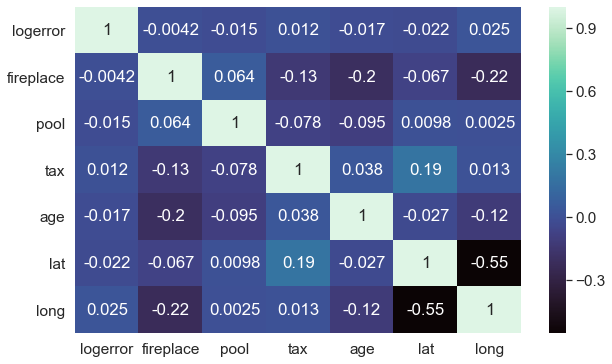

In [89]:
plt.figure(figsize = (10,6))
g = sns.heatmap(zillow_vars.corr(), annot=True, cmap = "mako")


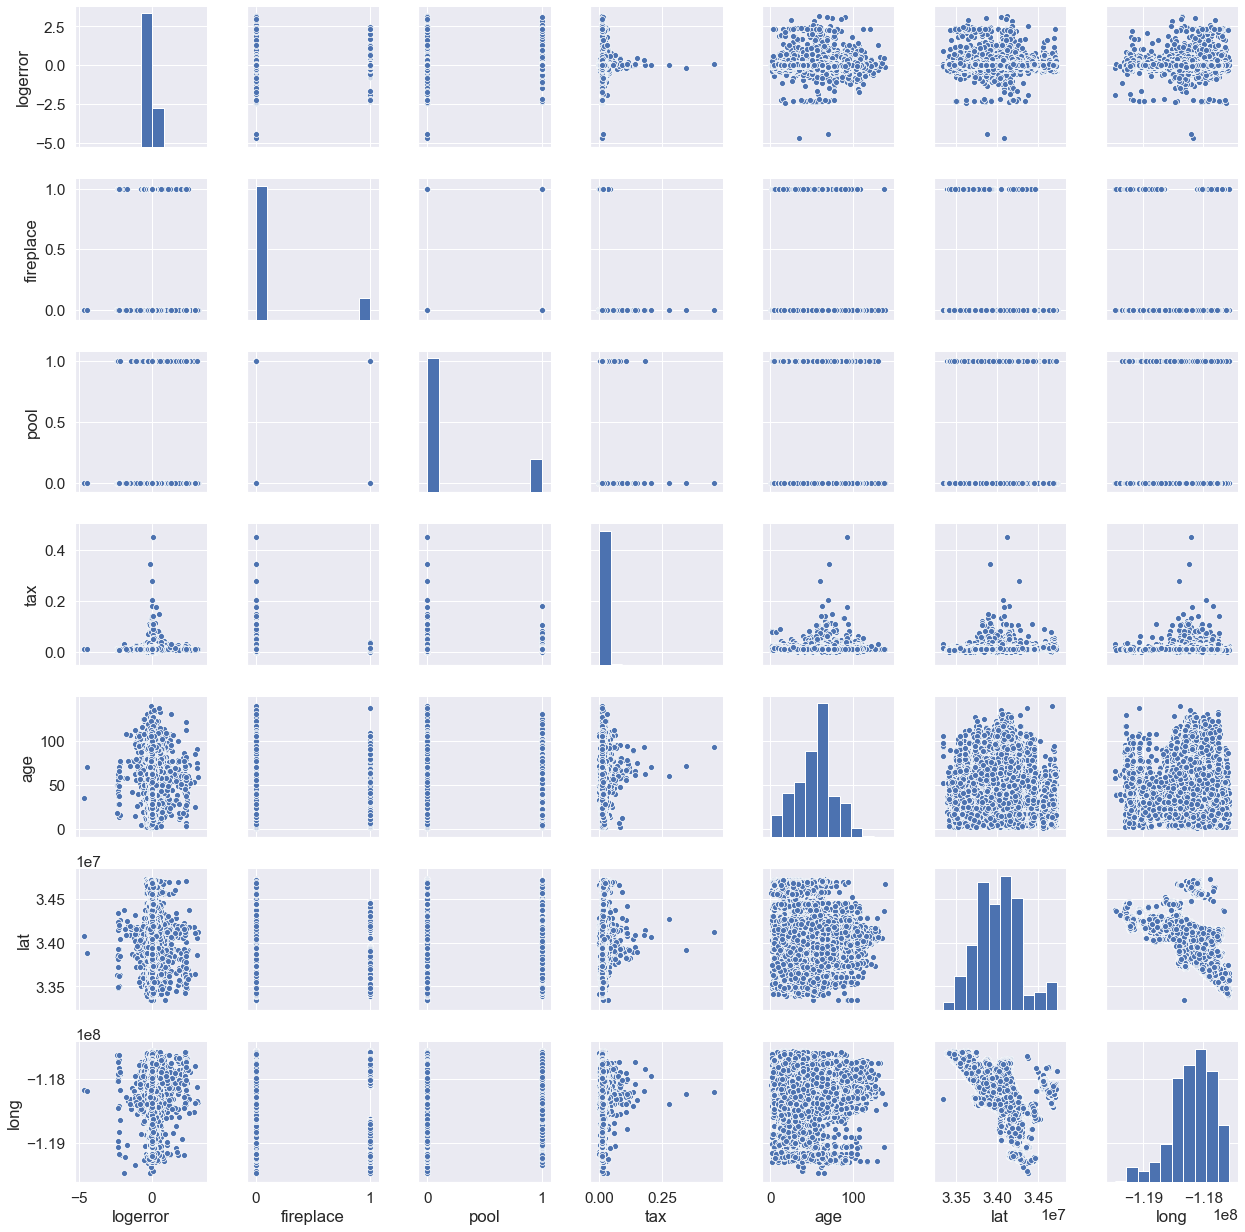

In [90]:
sns.pairplot(zillow_vars)

### Exploring: Clustering on logerror

   k          sse
0  1  1445.684125
1  2   877.775933
2  3   622.560065
3  4   427.292745
4  5   313.957583
5  6   228.488559
6  7   170.167134
7  8   132.491249
8  9   105.894565


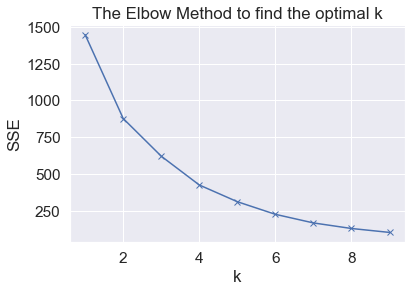

In [100]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(zillow[['logerror']])

    # inertia: Sum of squared distanes of samplesto their closest cluster
    sse.append(kmeans.inertia_)
print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method to find the optimal k')
plt.show()

In [108]:
kmeans = KMeans(n_clusters = 7)
kmeans.fit(zillow[['logerror']])

zillow['cluster_7'] = kmeans.predict(zillow[['logerror']])
zillow.cluster_7.value_counts()
zillow.cluster_7 = 'cluster_' + zillow.cluster_7.astype('str')

In [109]:
zillow.cluster_7.value_counts()

cluster_1    33368
cluster_0    10561
cluster_3     3686
cluster_4      647
cluster_6      534
cluster_2      109
cluster_5       34
Name: cluster_7, dtype: int64

In [110]:
kmeans.cluster_centers_

array([[-0.07617844],
       [ 0.01940539],
       [ 2.15220437],
       [ 0.20634482],
       [-0.44829785],
       [-2.20639594],
       [ 0.69700067]])

In [111]:
pd.DataFrame(kmeans.cluster_centers_, columns=zillow[['logerror']].columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,logerror
cluster,
0,-0.076178
1,0.019405
2,2.152204
3,0.206345
4,-0.448298
5,-2.206396
6,0.697001


(0, 8)

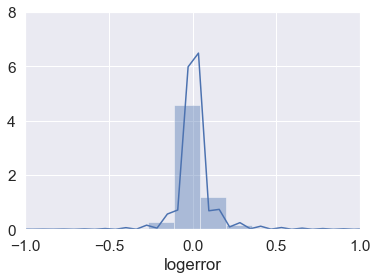

In [93]:
sns.distplot(zillow.logerror)
plt.axlim(-1,1)
plt.ylim(0,8)

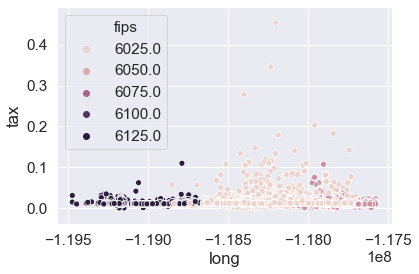

In [91]:
sns.scatterplot(x = 'long', y = 'tax', data=zillow, hue='fips')

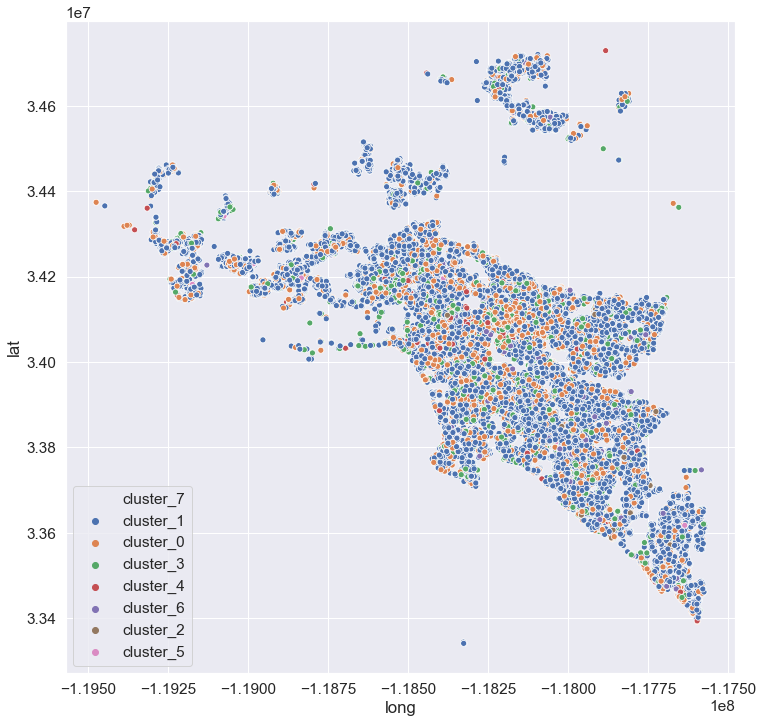

In [112]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='long', y='lat', data=zillow, hue='cluster_7')

In [ ]:
plt.figure(figsize = (12,12))
sns.scatterplot(x='long', y='lat', data=zillow, hue='cluster_7')